### Importing libraries and setting some global settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
plt.rcParams['text.usetex'] = True

### JCIR basics
The JCIR model is an extension of the CIR model. The tracked quantity (in our case an intensity $\lambda$) moves according to the dynamics

$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$


where $\mu_\lambda$ represent the standard $\lambda$ that is reverted to, $\kappa$ is the reversion speed, $v_\lambda$ is the diffusion variance, and $dJ_t^{\alpha, \gamma}$ is a jump process with jump arrival rate $\alpha$ and jump sizes drawn from an exponential distribution with mean $\gamma$. (See e.g. Brigo Book pg. 76)

### A naive implementation
A naive way to implement the JCIR process is to run an euler marayuma process for the diffusion element, and to simulate a list of jumps beforehand which are inserted when they occur, this is demonstrated in the first code cell below.


Jump Times: [ 2.85512254  8.63509212 11.54772087 12.38982414 14.99409116 23.16661767
 49.12974398]
Jump Intensities: [0.05958786974131642, 0.5423564502286795, 0.12895500341300203, 0.039278947129184616, 0.6427492526845187, 1.2165369963793662, 0.110044214449094]


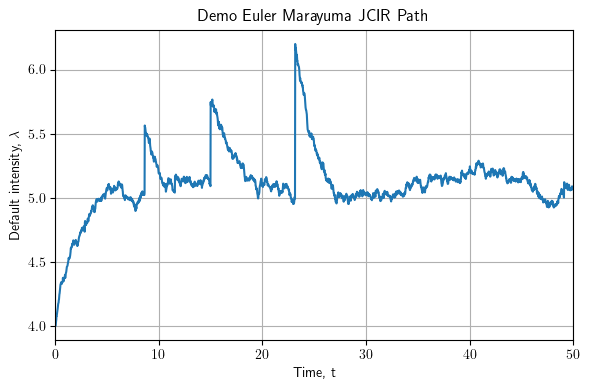

In [8]:
t0 = 0
T = 50

lambda0 = 4
mu = 5
kappa = 0.5
v = 0.25

alpha = 5/T # We should expect to see about 5 jumps,
gamma = mu/10 # With expected size mu/10

rand = Generator(PCG64())

## Generate Jumps
jump_times = t0 + (T-t0)*rand.random(rand.poisson(alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps
print("Jump Times: " + str(jump_times))
print("Jump Intensities: " + str(jump_intensitys))

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run diffusion model for let's say 2500 time steps over our 50 time units, i.e. dt = 1/50
N = 2500
t_s = np.linspace(t0,T,N)
lambdas = np.linspace(lambda0,lambda0,N)

for i in np.arange(1,N):
    dt = (T-t0)/N
    lambdas[i] = lambdas[i-1] + kappa*(mu-lambdas[i-1])*dt + v*np.sqrt(lambdas[i-1])*rand.normal()*dt

    # Add jump with naive implementation (We could allow jumps to create sub time steps to add them at exactly the right time but why bother)
    if not not jumps:
        if jumps[0][0] < t_s[i]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            jumps.pop(0)
            
    # Force positivity
    lambdas[i] = max(lambdas[i],0)
    # 
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas)
ax1.set_title("Demo Euler Marayuma JCIR Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
plt.show()

